# Demonstration 4: Simple Neural Network in Python


**1. Import Modules**  
Once again, let's import a few modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib           import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

**2.  Define helper functions**  
we need   
* binary data
* functions to plot results


In [225]:
def generateData(v1=2,v2=1,numSamples=1000):
    # generates data set for binary classification that can't be separated
    # by a linear boundary in 2D    
    samplesPerClass = numSamples//2
    numAngles = 100
    samplesPerAngle = samplesPerClass//numAngles
    
    # isotropic multivariate gaussian
    cat1 = np.random.multivariate_normal([0,0],[[v1,0],[0,v1]],numSamples//2)
    phis = np.linspace(0,2.0*np.pi,numAngles)
    phis = phis[:,np.newaxis]
    # donut (circle with univariate gaussian noise)
    cat2 = np.array([])
    for ii,phi in enumerate(phis):
        newSample = np.array([(v2*np.random.randn(samplesPerAngle)+5)*np.cos(phi),(v2*np.random.randn(samplesPerAngle)+5)*np.sin(phi)]).T            
        cat2 = np.vstack((cat2,newSample)) if len(cat2)!=0 else newSample 
    
    xData = np.vstack((cat1,cat2))
    yData = np.vstack((np.zeros((numSamples//2,1)),np.ones((numSamples//2,1))))
    shuffIdces = np.random.permutation(numSamples) 
    xData   = xData[shuffIdces,:]
    yData   = yData[shuffIdces,:]    
    return xData,yData


def plotScatterData(x,y,legendStr=['class A','class B'],titleStr='data'):
    plt.figure()
    plt.plot(x[y[:,0]==0,0],x[y[:,0]==0,1],'o',color='blue')
    plt.plot(x[y[:,0]==1,0],x[y[:,0]==1,1],'o',color='red')
    plt.title(titleStr)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(legendStr)
    
def plotLossSurface(x,y,z,xLabel='theta1',yLabel='theta2',zLabel='Loss',titleStr='loss surface'):
    # 1. surface plot
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(x,y,z,cmap=cm.coolwarm)    
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel(zLabel)
    ax.set_title(titleStr)
    
def plotLossTrajectory(x,y,z,th,lo,xLabel='theta1',yLabel='theta2',zLabel='Loss',titleStr='loss trajectory'):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(x,y,z,cmap=cm.coolwarm)
    ax.plot3D(th[:,1],th[:,2],lo,'-o',color='red')
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel(zLabel)
    ax.set_title(titleStr)

def plotLossCurve(x,y,titleStr='training loss'):
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(x,y,'-',color='blue')
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss')
    ax.set_title(titleStr)

**3. Generate and visualise some toy data**  
Let's first generate some toy data and display it as scatter plot!

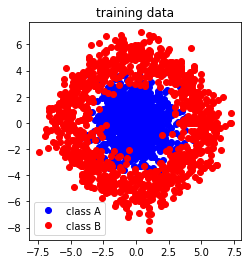

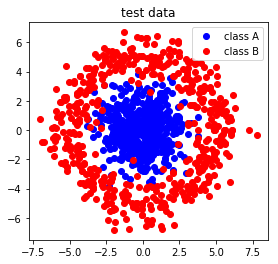

In [226]:
# define parameters
nTrainingSamples = 2000
nTestSamples     = 1000

# generate data
xTrain,yTrain = generateData(numSamples=nTrainingSamples)
xTest,yTest   =     generateData(numSamples=nTestSamples)


# display data
plotScatterData(xTrain,yTrain,titleStr='training data')
plotScatterData(xTest,yTest,titleStr='test data')

# add constant terms 
xTrain = np.concatenate((np.ones((nTrainingSamples,1)),xTrain),axis=1)
xTest = np.concatenate((np.ones((nTestSamples,1)),xTest),axis=1)


** 4. Build the model **  
We'll define the neural network as object


In [227]:
class NeuralNetwork():
    def __init__(self,numInputs,numHidden,numOutputs):
        self.numInputs  = numInputs
        self.numHidden  = numHidden
        self.numOutputs = numOutputs
        
        self.W_h = np.random.randn(self.numInputs,self.numHidden)
        self.W_o = np.random.randn(self.numHidden,self.numOutputs)
                

    def linearFunction(self,x,thetas):
        # defines a simple linear function 
        return np.dot(x,thetas)

    def logisticFunction(self,x):
        # defines a logistic function
        return 1.0/(1.0+np.exp(-x))

    def lossFunction(self,y_true,y_hat):
        # cross entropy loss
        y_true = y_true.reshape((-1,1))
        loss = -np.mean(y_true*np.log(y_hat+1e-10)+(1-y_true)*np.log(1-y_hat+1e-10))
        return loss
    
    def fprop(self,x):
        # this implements forward-propagation
        # returns layer activations
        
        # input to hidden layer:        
        h_l = self.linearFunction(x,self.W_h)        
        h_z = self.logisticFunction(h_l)
        
        # hidden layer to output layer:
        o_l = self.linearFunction(h_z,self.W_o)         
        o_z = self.logisticFunction(o_l) 
        
        layerActivations = {"hidden_lin": h_l,
                           "hidden_sig":h_z,
                           "out_lin": o_l,
                           "out_sig":o_z}
        
        return layerActivations
    
    def bprop(self,x,y,layerActivations):
        # we called this "lossGradient" in prev
        # example.
        # this basically implements backpropagation
        
        # derivative of loss wrt its input
        dO_c = ((1-y)/(1-layerActivations["out_sig"]))-(y/layerActivations["out_sig"])   
        #derivative of sigmoid wrt its input
        dO_z = layerActivations["out_sig"]*(1-layerActivations["out_sig"])
        # total error of output layer: 
        Ey = dO_c*dO_z        
        # gradient in output layer (wrt its weights)
        dO_w = np.dot(Ey.T,layerActivations["hidden_sig"])        
        
        # total error of output layer wrt its input (the quantity we propagate to prev layers):
        dO_l = np.dot(Ey,self.W_o.T)
        
        
        # derivate of sigmoid in hidden wrt its input
        dH_z = layerActivations["hidden_sig"]*(1-layerActivations["hidden_sig"])
        # error in hidden layer:
        Eh = dO_l*dH_z        
        # gradient in hidden layer (wrt its weights:
        dH_w = np.dot(Eh.T,x)
        
        
        # total error wrt input of hidden layer
        dH_l = np.dot(Eh,self.W_h.T)
        
        # dictionary of gradients
        gradients = {'grad_out': dO_w,
                    'grad_hidden':dH_w}
        return gradients   
    
        
    def runSGD(self,x,y,numIters=2,lrate=0.03):
        # performs stochastic gradient descent
        losses = np.empty((numIters))        
        for ii in range(numIters):
            outs = self.fprop(x)
            losses[ii] = self.lossFunction(y,outs['out_sig'])
            gradients = self.bprop(x,y,outs)
            # update weights:            
            self.W_o = self.W_o-lrate*gradients['grad_out'].T            
            self.W_h = self.W_h-lrate*gradients['grad_hidden'].T
        return losses
    
    def predict(self,x):
        return self.fprop(x)['out_sig']

** 7. Train the model**  
Now we train the model

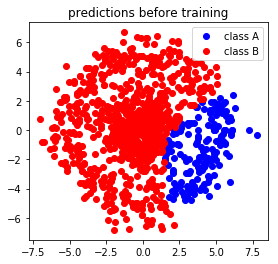

In [228]:
# parameters:
numIters = 1000
epsilon = 0.005

# initialise the model
nnet = NeuralNetwork(3,10,1)

# show results for initialised (i.e. untrained) function
yTest_pred = nnet.predict(xTest) > 0.5

plotScatterData(xTest[:,1:],yTest_pred,titleStr='predictions before training')

# train the model
loss = nnet.runSGD(xTrain,yTrain,numIters=numIters,lrate=epsilon)
yTest_pred = nnet.predict(xTest) > 0.5



** 8. Evaluate the model**   
Let's have a look at the results

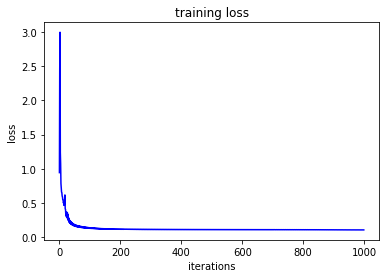

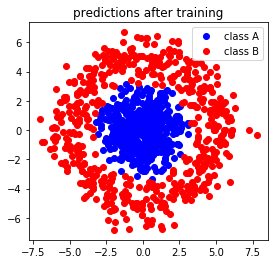

In [229]:

# plot loss function
plotLossCurve(np.arange(1000),loss)


# show fitted function
plotScatterData(xTest[:,1:],yTest_pred,titleStr='predictions after training')